## Imports

In [67]:
import collections
import os
import string
import sys
import nltk

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

nltk.download('punkt')

import sys
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alicemahiant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [68]:
data_path = "../data/txt/"

In [69]:
DECADE = '1960'

## Charging all the decade's files and making it a list of texts

In [70]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [71]:
texts = [open(data_path + f).read() for f in files]

## Vectorizing the files with TF-IDF

In [72]:
# creating a pre-treatment function
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instanciating the TF-IDF model with its arguments

In [73]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Constructing the matrice with the `fit_transform` function

In [74]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [75]:
# details about the matrice
tfidf_vectors

<1000x2997 sparse matrix of type '<class 'numpy.float64'>'
	with 591250 stored elements in Compressed Sparse Row format>

## Applying a clustering algorithm on the TF-IDF vectors of the documents

### Setting the number of clusters

In [76]:
N_CLUSTERS = 3

### Instanciate the K-Means model and its arguments

In [77]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Applying the clustering with the function `fit_predict`

In [78]:
clusters = km_model.fit_predict(tfidf_vectors)

In [79]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

## Visualizing the clusters

### Reducing the vectors to 2D with the PCA algorithm

In [80]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

### Generating the plot

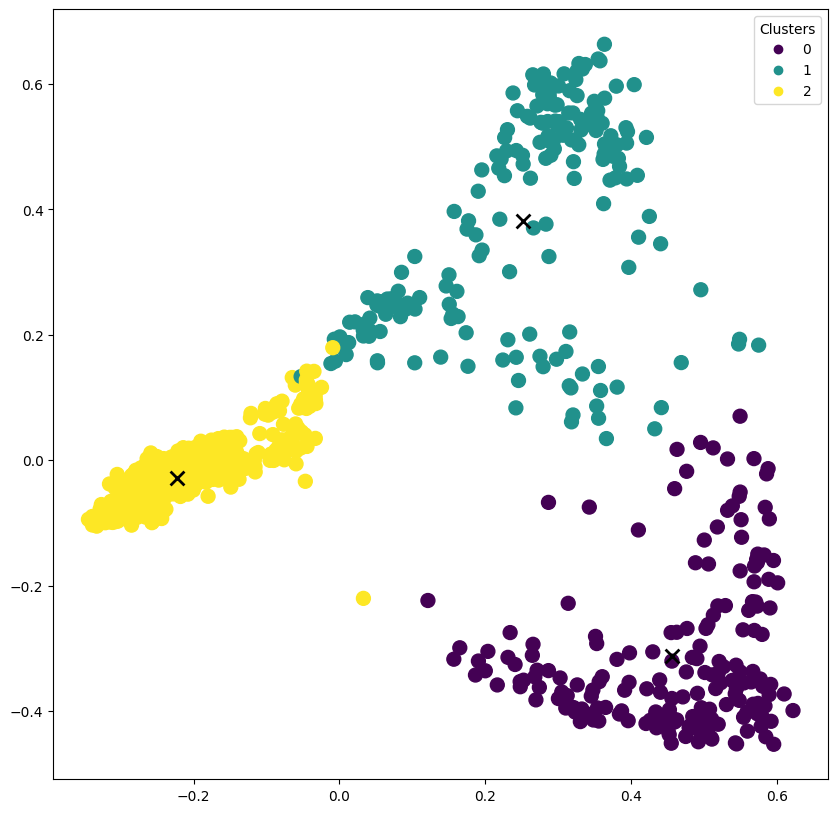

In [81]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Words embeddings

## Segmentation in sentences : input and output files

In [82]:
infile = "../data/txt/all.txt"
outfile = "../data/sents.txt"

## Charging and treating the corpus's sentences

### Creating an object *streaming* the file's lines to save RAM

In [83]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [84]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

### Detecting the bigrams

In [85]:
bigram_phrases = Phrases(sentences)

L'object `phrases` peut être vu comme un large dictionnaire d'expressions multi-mots associées à un score, le *PMI-like scoring*. Ce dictionnaire est construit par un apprentissage sur base d'exemples.
Voir les références ci-dessous :
- https://arxiv.org/abs/1310.4546
- https://en.wikipedia.org/wiki/Pointwise_mutual_information

In [86]:
type(bigram_phrases.vocab)

dict

### Printing the numbers of keys (= different terms) observed in the corpus

In [87]:
len(bigram_phrases.vocab.keys())

15761694

### Let's have a look at a random key :

In [102]:
key_ = list(bigram_phrases.vocab.keys())[5]
print(key_)

exemplaires


### The dictionnary shows the score of this cooccurence :

In [89]:
bigram_phrases.vocab[key_]

1

Lorsque l'instance de `Phrases` a été entraînée, elle peut concaténer les bigrams dans les phrases lorsque c'est pertinent.

### Conversion of the `Phrases` into an object `Phraser`

In [90]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

### Trigrams extraction

### Repeating the operation with the bigrams list to extract trigrams

In [91]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [92]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Creating a corpus of unigrams, bigrams and trigrams

In [93]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [94]:
print(corpus[:100])

[['raege', 'quotidien', 'j00', 'exemplaires_distribues', 'gratuitement', '#', 'k', '.', "'", 'dans', 'ilagg', ';', 'lomeration', 'bruxelloise', 'et', '.', 'en_province', '.'], ['i', 'personnes_habitant', 'aux_etages', 'fenile', 'journal_contre', '60', 'c', '"<<', 'par_mois', '.'], ['fspir', 'est', 'expedie', 'en', 'proyinoe', 'contre', 't', '*>>"', 'par_mois', ',', 'payables_par_trimestre', '.'], ['annonces', ',', 'faits_divers', 'et', 'reclames', 'sjont', 'recu', 'frie', 'd', "'", 'isabelle', ';', 'a', 'l', "'", 'agence', 'rossfjl', '.'], ['44', '.'], ['-', 'v', ',', 'et', 'do', 'l', "'", 'enseignement', ',', 'a', 'braxell', 'annonces_remises_avant', 'midi', 'sont', ';', '-', 'a', ";'%", '>', '1', 'v', '>>^.'], [':', 'vv', '*', "*'*", 'hv', '/', 'f', '#-', 'v', '1', 'v', ';', "'", 'y', '>', 'fif', "'", 'ji', 'l', "'", 'h', '-', 'et', '.'], ['jeudi', '22', 'decembre', 'i887', 'observatoire', 'roy', "&'", 'cs', 'io', 'decembre', 's', 'heurts', 'uat', '$', 'r', '-:', 'r', 'quotidien_grat

## Training a Word2Vec model onto this corpus

In [95]:
%%time
model = Word2Vec(
    corpus, # setting the ngrams corpus we just created
    vector_size=32, # setting the number of dimensions into which the context of the words should be reducted, aka. vector_size
    window=5, # setting the context size, aka. the window
    min_count=5, # ignoring the words appearing less than 5 times in the corpus
    workers=4, # parallelizing the training in 4 threads
    epochs=5 # setting the number of neural network iterations on the dataset to adjust parameters with gradient descent, aka. epochs
)

CPU times: user 4min 43s, sys: 15.5 s, total: 4min 58s
Wall time: 2min


#### Remarque

Vous voyez ici que l'entrainement du modèle est parallélisé (sur 4 workers).

Lors qu'on parallélise l'entrainement du modèle, 4 modèles "séparés" sont entrainés sur environ un quart des phrases.

Ensuite, les résultats sont agrégés pour ne plus faire qu'un seul modèle.

On ne peut prédire quel worker aura quelle phrase, car il y a des aléas lors de la parallélisation (p. ex. un worker qui serait plus lent, etc.).

Du coup, les valeurs peuvent varier légèrement d'un entrainement à l'autre.

Mais, globalement, les résultats restent cohérents.

### Sauver le modèle dans un fichier

In [96]:
outfile = f"../data/newspapers.model"
model.save(outfile)

## Explorer le modèle

### Charger le modèle en mémoire

In [97]:
model = Word2Vec.load("../data/newspapers.model")

### Imprimer le vecteur d'un terme

In [103]:
model.wv["premier"]

array([-2.6277834e-01,  1.1784025e+00, -3.0678144e+00, -1.9789417e+00,
        2.0686374e+00,  3.0541227e-03,  1.5507269e+00,  1.8722469e+00,
        1.3532680e+00,  9.0142262e-01, -8.4523588e-01, -2.1460471e+00,
       -6.4697027e-02, -7.2482387e-03, -4.1854736e-01,  2.3126009e+00,
       -9.1086161e-01,  5.3814761e-02, -5.5842400e-01, -3.8966963e+00,
        4.4934250e-02,  1.4840511e+00, -1.9481508e+00,  5.2888961e+00,
        1.3575518e+00,  3.6301565e+00, -5.3319869e+00,  4.0474195e+00,
       -3.1389825e+00, -1.7826718e+00, -4.2051476e-01, -1.5286504e+00],
      dtype=float32)

### Measuring the similarity between two words for three different associations

In [122]:
model.wv.similarity("firme", "fiat")

0.0052227005

In [123]:
model.wv.similarity("division", "equipe")

0.7414601

In [125]:
model.wv.similarity("premier", "football")

0.5754781

### Looking for the first 10 most similar words for three different words

In [110]:
model.wv.most_similar("suite", topn=10)

[('suito', 0.7503401041030884),
 ('partie', 0.7450459003448486),
 ('reception', 0.7227106690406799),
 ('derniere_minute', 0.7191717028617859),
 ('notification', 0.7113757133483887),
 ('date', 0.7113150954246521),
 ('besogne', 0.7008219361305237),
 ('composition_definitive', 0.6994317770004272),
 ('tournee', 0.694709062576294),
 ('course_cycliste', 0.691099226474762)]

In [115]:
model.wv.most_similar("aide", topn=10)

[('expediteur', 0.7668196558952332),
 ('operateur', 0.7366382479667664),
 ('laveur', 0.7227104306221008),
 ('agent', 0.7174308896064758),
 ('ouvrier', 0.7142072319984436),
 ('infirmiere', 0.7121555805206299),
 ('emploi', 0.7085165977478027),
 ('econome', 0.7072897553443909),
 ('hotesse', 0.7047210335731506),
 ('urgence', 0.6887214779853821)]

In [116]:
model.wv.most_similar("frs", topn=10)

[('fr', 0.9157966375350952),
 ('franos', 0.8315844535827637),
 ('fir', 0.8197395205497742),
 ('kilogr', 0.814021110534668),
 ('rrancs', 0.8121218085289001),
 ('fb', 0.8092435002326965),
 ('m3', 0.8054502606391907),
 ('franca', 0.8051060438156128),
 ('100_fr', 0.8028212189674377),
 ('000_franc', 0.8003799319267273)]

### Faire des recherches complexes à travers l'espace vectoriel

In [101]:
print(model.wv.most_similar(positive=['paris', 'londres'], negative=['belgique']))

[('berlin', 0.7962397933006287), ('new_york', 0.7724714279174805), ('rome', 0.7674779295921326), ('datee_du', 0.7641447186470032), ('tokio', 0.7608868479728699), ('berlin_berlin', 0.753424346446991), ('lundi_prochain', 0.7528833746910095), ('tanger', 0.7514708042144775), ('moscou', 0.7468673586845398), ('vienne', 0.7460483312606812)]
